In [ ]:
Mean Squared Error (MSE): 0.0769
Root Mean Squared Error (RMSE): 0.2773
R² Score: 0.9936
MAE: 0.063

#  LSTM은 시간에 따른 데이터 추이를 가지기 때문에 반드시 입력값을 정렬해줘야함 -> 시간에 따라 변화하는 방향으로

In [62]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from numpy import array
from sklearn.utils import shuffle

# 함수: 시퀀스를 샘플로 분할
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def feature_eng(df):
    
#     # 특성 엔지니어링
#     df['Length_to_Diameter'] = df['Length'] / df['Diameter']
#     df['Weight_Ratio'] = df['Shucked_weight'] / df['Whole_weight']

#     df['Water'] = df['Whole_weight'] - df['Shucked_weight'] - df['Viscera_weight'] - df['Shell_weight']
#     df['new'] = df['Shell_weight']+df['Height']
#     df['Length_Diameter_Product'] = df['Length'] * df['Diameter']
#     df['Shell_Weight_Ratio'] = df['Shell_weight'] / df['Whole_weight']

    # 부피와 밀도 계산 전에 0으로 나누는 것을 방지
    df['Volume'] = df['Length'] * df['Height'] * df['Diameter']
#     df['Density'] = df['Whole_weight'] / df['Volume']
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)  # 무한대 값 NaN으로 대체
#     df.dropna(inplace=True)  # NaN 값 제거
    
    return df


# 데이터 로드
url = 'https://raw.githubusercontent.com/MyungKyuYi/AI-class/main/abalone.csv'
data = pd.read_csv(url)

# 시계열 데이터를 만들기 위해 Rings를 기준으로 오름차순 정렬
# Rings가 동일한 데이터일 경우 가장 Rings에 대해 영향이 큰 Shell_weight를 기준으로 재정렬
data = data.sort_values(by=['Rings', 'Shell_weight'], ascending=[True, True])

# 'Rings' 열을 0부터 시작하도록 조정
data['Rings'] = data['Rings'] - 1

data

,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
236,236,I,0.075,0.055,0.010,0.0020,0.0010,0.0005,0.0015,0
719,719,I,0.150,0.100,0.025,0.0150,0.0045,0.0040,0.0050,1
238,238,I,0.110,0.090,0.030,0.0080,0.0025,0.0020,0.0030,2
237,237,I,0.130,0.100,0.030,0.0130,0.0045,0.0030,0.0040,2
1429,1429,I,0.140,0.105,0.035,0.0140,0.0055,0.0025,0.0040,2
...,...,...,...,...,...,...,...,...,...,...
2201,2201,F,0.645,0.490,0.215,1.4060,0.4265,0.2285,0.5100,24
294,294,M,0.600,0.495,0.195,1.0575,0.3840,0.1900,0.3750,25
2209,2209,F,0.550,0.465,0.180,1.2125,0.3245,0.2050,0.5250,26
2108,2108,M,0.665,0.535,0.225,2.1835,0.7535,0.3910,0.8850,26


In [63]:
# 'Rings'를 예측 타겟으로 사용
target = data['Rings'].values

# 특성공학 
data = feature_eng(data)


# 특성 선택 및 데이터 스케일링
features = data.drop(['Rings', 'Sex','id'], axis=1)  # 성별 제거


scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 시계열 데이터 형식으로 변환 (예: 3개의 타임 스텝 사용)
n_steps = 3
X, y = split_sequence(target, n_steps)

# LSTM 입력 형식에 맞게 데이터 차원 변경
X = X.reshape((X.shape[0], X.shape[1], 1))

# 데이터 분할 --> 훈련 및 검증까지 train 데이터로 할 것임
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 성능 평가를 위한 데이터셋 섞음
X_test, y_test = shuffle(X_test, y_test, random_state=48)




In [64]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# 모델 구성
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer='l2'), input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(32, kernel_regularizer='l2'),
    Dropout(0.2),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')



C:\Users\Hyeon\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1)

# 모델 훈련
history = model.fit(X_train, y_train, epochs=2000, batch_size=32,  validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])



Epoch 1/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 81.1789 - val_loss: 64.8622 - learning_rate: 1.0000e-04
Epoch 2/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.5923 - val_loss: 36.5511 - learning_rate: 1.0000e-04
Epoch 3/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.0610 - val_loss: 20.2816 - learning_rate: 1.0000e-04
Epoch 4/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.3420 - val_loss: 14.5325 - learning_rate: 1.0000e-04
Epoch 5/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.9539 - val_loss: 12.4855 - learning_rate: 1.0000e-04
Epoch 6/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.9361 - val_loss: 11.5244 - learning_rate: 1.0000e-04
Epoch 7/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.5142 - val_loss: 10.8896 - learning_rate: 1.0000e-04
Epoch 8/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8860 - val_loss: 10.2665 - learning_rate: 1.0000e-04
Epoch 9/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6773 - val_

Epoch 56/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7804 - val_loss: 1.3617 - learning_rate: 1.0000e-04
Epoch 57/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9104 - val_loss: 1.3156 - learning_rate: 1.0000e-04
Epoch 58/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6788 - val_loss: 1.2795 - learning_rate: 1.0000e-04
Epoch 59/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6942 - val_loss: 1.2460 - learning_rate: 1.0000e-04
Epoch 60/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6676 - val_loss: 1.2040 - learning_rate: 1.0000e-04
Epoch 61/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6001 - val_loss: 1.1707 - learning_rate: 1.0000e-04
Epoch 62/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8902 - val_loss: 1.1286 - learning_rate: 1.0000e-04
Epoch 63/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6086 - val_loss: 1.0990 - learning_rate: 1.0000e-04
Epoch 64/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6047 - val_loss: 

Epoch 111/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9902 - val_loss: 0.3695 - learning_rate: 1.0000e-04
Epoch 112/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9386 - val_loss: 0.3584 - learning_rate: 1.0000e-04
Epoch 113/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9473 - val_loss: 0.3696 - learning_rate: 1.0000e-04
Epoch 114/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9400 - val_loss: 0.3800 - learning_rate: 1.0000e-04
Epoch 115/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8919 - val_loss: 0.3405 - learning_rate: 1.0000e-04
Epoch 116/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9989 - val_loss: 0.3297 - learning_rate: 1.0000e-04
Epoch 117/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9511 - val_loss: 0.3286 - learning_rate: 1.0000e-04
Epoch 118/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9869 - val_loss: 0.3327 - learning_rate: 1.0000e-04
Epoch 119/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8832 - v

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7617 - val_loss: 0.1939 - learning_rate: 1.0000e-04
Epoch 166/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8338 - val_loss: 0.1997 - learning_rate: 1.0000e-04
Epoch 167/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8078 - val_loss: 0.1891 - learning_rate: 1.0000e-04
Epoch 168/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8006 - val_loss: 0.2103 - learning_rate: 1.0000e-04
Epoch 169/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8484 - val_loss: 0.1865 - learning_rate: 1.0000e-04
Epoch 170/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8369 - val_loss: 0.2015 - learning_rate: 1.0000e-04
Epoch 171/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8165 - val_loss: 0.1824 - learning_rate: 1.0000e-04
Epoch 172/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8104 - val_loss: 0.1849 - learning_rate: 1.0000e-04
Epoch 173/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8184 - val_loss: 0.1835

Epoch 220/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7279 - val_loss: 0.1832 - learning_rate: 1.0000e-04
Epoch 221/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7740 - val_loss: 0.1334 - learning_rate: 1.0000e-04
Epoch 222/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7459 - val_loss: 0.1351 - learning_rate: 1.0000e-04
Epoch 223/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7371 - val_loss: 0.1599 - learning_rate: 1.0000e-04
Epoch 224/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7602 - val_loss: 0.1369 - learning_rate: 1.0000e-04
Epoch 225/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7655 - val_loss: 0.1294 - learning_rate: 1.0000e-04
Epoch 226/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7549 - val_loss: 0.1281 - learning_rate: 1.0000e-04
Epoch 227/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8070 - val_loss: 0.1298 - learning_rate: 1.0000e-04
Epoch 228/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6951 - v

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6775 - val_loss: 0.1058 - learning_rate: 1.0000e-04
Epoch 275/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7358 - val_loss: 0.1075 - learning_rate: 1.0000e-04
Epoch 276/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7446 - val_loss: 0.1196 - learning_rate: 1.0000e-04
Epoch 277/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7185 - val_loss: 0.1045 - learning_rate: 1.0000e-04
Epoch 278/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6682 - val_loss: 0.1046 - learning_rate: 1.0000e-04
Epoch 279/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7817 - val_loss: 0.1088 - learning_rate: 1.0000e-04
Epoch 280/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7408 - val_loss: 0.1308 - learning_rate: 1.0000e-04
Epoch 281/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7130 - val_loss: 0.1046 - learning_rate: 1.0000e-04
Epoch 282/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6597 - val_loss: 0.1029

Epoch 329/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7172 - val_loss: 0.0903 - learning_rate: 1.0000e-04
Epoch 330/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6873 - val_loss: 0.1029 - learning_rate: 1.0000e-04
Epoch 331/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6691 - val_loss: 0.0946 - learning_rate: 1.0000e-04
Epoch 332/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6572 - val_loss: 0.0879 - learning_rate: 1.0000e-04
Epoch 333/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6125 - val_loss: 0.1025 - learning_rate: 1.0000e-04
Epoch 334/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6787 - val_loss: 0.0896 - learning_rate: 1.0000e-04
Epoch 335/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7250 - val_loss: 0.0909 - learning_rate: 1.0000e-04
Epoch 336/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6973 - val_loss: 0.0865 - learning_rate: 1.0000e-04
Epoch 337/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6570 - v

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6720 - val_loss: 0.0755 - learning_rate: 1.0000e-04
Epoch 384/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6337 - val_loss: 0.0728 - learning_rate: 1.0000e-04
Epoch 385/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5754 - val_loss: 0.0771 - learning_rate: 1.0000e-04
Epoch 386/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7109 - val_loss: 0.0751 - learning_rate: 1.0000e-04
Epoch 387/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6179 - val_loss: 0.0791 - learning_rate: 1.0000e-04
Epoch 388/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6531 - val_loss: 0.0716 - learning_rate: 1.0000e-04
Epoch 389/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6128 - val_loss: 0.0782 - learning_rate: 1.0000e-04
Epoch 390/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6502 - val_loss: 0.0788 - learning_rate: 1.0000e-04
Epoch 391/2000
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6846 - val_loss: 0.0823

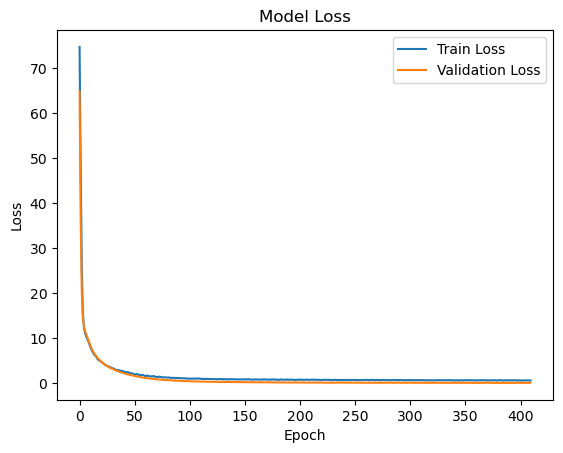

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Mean Squared Error (MSE): 0.0769
Root Mean Squared Error (RMSE): 0.2773
R² Score: 0.9936
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAE: 0.063


In [66]:
import matplotlib.pyplot as plt


# 훈련 과정 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 성능 평가
y_pred = model.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

yhat = model.predict(X_test)
error = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % error)